# Steps

1. Build a `RunOptions` generator with the parameters of interest, namely $dim_S, J_S, \delta_S, U_S, dim_A, J_A, \delta_A, U_A, \alpha_{xx}, \alpha_{xz}, \alpha_{zx}, \alpha_{zz}, t$. We need a decent range for $\delta_S$ for the Bayesian update side of things. We assume a uniform prior on the cartesian product.
2. Calculate the probabilities for the $J_z$ measurement for each value. This is a `dict`, as $J_z$ can have multiple outcomes.
3. Use the probabilities to build the expected likelihood function over all inputs, for a given range of $N_{trials}$. This also requires a "True" set of values for each parameter.
4. Use the likelihood to build the marginal distribution for all variables.
5. Save the std variation for each estimated variable!
6. Plot $\Delta$ agains the $N_{trials}$, keeping the parameters of the plot saved

In [1]:
from dataclasses import dataclass, field
from src.angular_momentum import generate_spin_matrices
from tqdm import tqdm
import functools
import itertools
import numpy as np
import pandas as pd
import scipy
from matplotlib.pyplot import figure

figure(figsize=(16, 6))

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

<Figure size 1600x600 with 0 Axes>

In [2]:
@dataclass
class Settings:
    dim_s: int
    dim_a: int
    probability_error_tolerance: float
    system_jx: np.array = field(init=False)
    system_jz: np.array = field(init=False)
    ancilla_jx: np.array = field(init=False)
    ancilla_jz: np.array = field(init=False)
    initial_state: np.array = field(init=False)

    def __post_init__(self):
        self.system_jx, self.system_jz = generate_spin_matrices(dim=self.dim_s)
        self.ancilla_jx, self.ancilla_jz = generate_spin_matrices(dim=self.dim_a)
        self.initial_state = np.zeros(self.dim_s * self.dim_a)
        self.initial_state[0] = 1
        self.initial_state = np.outer(self.initial_state, self.initial_state)

    def generate_hamiltonian(
        self,
        j_s: float,
        u_s: float,
        delta_s: float,
        j_a: float,
        u_a: float,
        delta_a: float,
        alpha_xx: float,
        alpha_xz: float,
        alpha_zx: float,
        alpha_zz: float,
    ) -> np.array:
        system_hamiltonian = np.kron(
            -1 * j_s * self.system_jx + u_s * self.system_jz @ self.system_jz + delta_s * self.system_jz,
            np.divide(np.eye(self.dim_a), self.dim_a)
        )
        ancillary_hamiltonian = np.kron(
            np.divide(np.eye(self.dim_s), self.dim_s),
            -1 * j_a * self.ancilla_jx + u_a * self.ancilla_jz @ self.ancilla_jz + delta_a * self.ancilla_jz
        )
        interaction_hamiltonian = functools.reduce(
            lambda x, y: x + y,
            [
                alpha_xx * np.kron(self.system_jx, self.ancilla_jx),
                alpha_xz * np.kron(self.system_jx, self.ancilla_jz),
                alpha_zx * np.kron(self.system_jz, self.ancilla_jx),
                alpha_zz * np.kron(self.system_jz, self.ancilla_jz),
            ]
        )
        return system_hamiltonian + ancillary_hamiltonian + interaction_hamiltonian

    def trace_out_ancillary(self, state: np.array):
        return np.trace(
            np.array(state).reshape(self.dim_s, self.dim_a, self.dim_s, self.dim_a),
            axis1=1,
            axis2=3
        )

    @staticmethod
    def calculate_final_state(
        hamiltonian: np.array,
        initial_state: np.ndarray,
        t: float = 0,
    ) -> np.array:
        return scipy.linalg.expm(-1j * t * hamiltonian) @ initial_state @ scipy.linalg.expm(1j * t * hamiltonian)

    def calculate_probabilities(self, final_state: np.array) -> np.array:
        system_state = self.trace_out_ancillary(state=final_state)
        probabilities = [np.abs(x)**2 for x in np.diag(system_state)] # TODO: Ensure these actually up to 1!!!
        # assert np.abs(np.sum(probabilities) - 1) < settings.probability_error_tolerance, f"⚠ The observed probabilities {probabilities} are unphysical by {np.abs(np.sum(probabilities) - 1):.5f}%"
        return probabilities

# Initial state $\ket{0} \otimes \ket{0}$

In [3]:
settings = Settings(
    dim_s= 2,
    dim_a= 1,
    probability_error_tolerance= .001,
)

In [4]:
pd.DataFrame(settings.initial_state).style.background_gradient(cmap='viridis')

,0,1
0,1.000000,0.000000
1,0.000000,0.000000


# Define true system

In [5]:
true_values = {
    "j_s": .2,
    "u_s": .1,
    "delta_s": 1.2,
    "j_a": .3,
    "u_a": .1,
    "delta_a": 1,
    "alpha_xx": 0,
    "alpha_xz": 0,
    "alpha_zx": 0,
    "alpha_zz": 0,
    "time": 5,
}

# Create generator object

In [6]:
df = pd.DataFrame([
    {
        "j_s": j_s,
        "u_s": u_s,
        "delta_s": delta_s,
        "j_a": j_a,
        "u_a": u_a,
        "delta_a": delta_a,
        "alpha_xx": alpha_xx,
        "alpha_xz": alpha_xz,
        "alpha_zx": alpha_zx,
        "alpha_zz": alpha_zz,
        "time": time
    }
    for j_s, u_s, delta_s, j_a, u_a, delta_a, alpha_xx, alpha_xz, alpha_zx, alpha_zz, time
    in itertools.product(
        np.linspace(.1999, .2001, 3), # j_s: float,
        np.linspace(.0999, .1001, 3), # u_s: float,
        np.linspace(1.1, 1.3, 101), # delta_s: float,
        [.3], # j_a: float,
        [.1], # u_a: float,
        [1], # delta_a: float,
        [0], # alpha_xx: float,
        [0], # alpha_xz: float,
        [0], # alpha_zx: float,
        [0], # alpha_zz: float,
        np.linspace(4.99, 5.01, 3), # time: float
    )],
)
df.sample(10).style.background_gradient(cmap='viridis', axis=0)

,j_s,u_s,delta_s,j_a,u_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time
1939,0.200100,0.099900,1.180000,0.300000,0.100000,1,0,0,0,0,5.000000
1872,0.200100,0.099900,1.136000,0.300000,0.100000,1,0,0,0,0,4.990000
488,0.199900,0.100000,1.222000,0.300000,0.100000,1,0,0,0,0,5.010000
710,0.199900,0.100100,1.168000,0.300000,0.100000,1,0,0,0,0,5.010000
77,0.199900,0.099900,1.150000,0.300000,0.100000,1,0,0,0,0,5.010000
2342,0.200100,0.100000,1.246000,0.300000,0.100000,1,0,0,0,0,5.010000
1328,0.200000,0.100000,1.176000,0.300000,0.100000,1,0,0,0,0,5.010000
420,0.199900,0.100000,1.178000,0.300000,0.100000,1,0,0,0,0,4.990000
995,0.200000,0.099900,1.156000,0.300000,0.100000,1,0,0,0,0,5.010000
497,0.199900,0.100000,1.228000,0.300000,0.100000,1,0,0,0,0,5.010000


# Calculate measurement probabilities

In [7]:
def calculate_measurement_probabilities(row: pd.Series) -> np.array:
    hamiltonian = settings.generate_hamiltonian(
        j_s = row["j_s"],
        u_s = row["u_s"],
        delta_s = row["delta_s"],
        j_a = row["j_a"],
        u_a = row["u_a"],
        delta_a = row["delta_a"],
        alpha_xx = row["alpha_xx"],
        alpha_xz = row["alpha_xz"],
        alpha_zx = row["alpha_zx"],
        alpha_zz = row["alpha_zz"]
    )
    final_state = settings.calculate_final_state(
        hamiltonian = hamiltonian,
        initial_state = settings.initial_state,
        t = row["time"],
    )
    # return final_state
    measurement_probabilities = settings.calculate_probabilities(final_state)
    return measurement_probabilities
    # return np.divide(final_probabilities, np.sum(final_probabilities))

df["probabilities"] = df.progress_apply(calculate_measurement_probabilities, axis=1) # i.e. Prob[J_z=k] for k in range(0, dim_s)
df["final_state_error"] = df.progress_apply(lambda row: np.abs(np.sum(row["probabilities"]) - 1), axis=1)

df.sample(30).style.background_gradient(cmap='viridis', axis=0)

100%|██████████| 2727/2727 [00:00<00:00, 75595.27it/s]


,j_s,u_s,delta_s,j_a,u_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time,probabilities,final_state_error
306,0.199900,0.100000,1.102000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9926354459743264, 1.360932360214676e-05]",0.007351
1910,0.200100,0.099900,1.160000,0.300000,0.100000,1,0,0,0,0,5.010000,"[0.9978776813880846, 1.1272555880537593e-06]",0.002121
2523,0.200100,0.100100,1.166000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9979624899006457, 1.0389205266144007e-06]",0.002036
2130,0.200100,0.100000,1.106000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.993068462267646, 1.2053364329486645e-05]",0.006919
1963,0.200100,0.099900,1.196000,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9993434038327543, 1.0781503008470245e-07]",0.000656
1542,0.200000,0.100100,1.118000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9943119811157479, 8.11147526815804e-06]",0.005680
811,0.199900,0.100100,1.236000,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9999933272513494, 1.1131430776441576e-11]",0.000007
447,0.199900,0.100000,1.196000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9992697884074884, 1.3335093410431096e-07]",0.000730
2113,0.200100,0.099900,1.296000,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9991341515645797, 1.8750456233534949e-07]",0.000866
1845,0.200100,0.099900,1.118000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9943080473755979, 8.122714717906552e-06]",0.005684


# Calculate likelihoods

In [8]:
true_likelihoods = calculate_measurement_probabilities(true_values)
# true_likelihoods /= np.prod(true_likelihoods)
true_likelihoods

[0.9994590595916262, 7.317392405786414e-08]

# Define n_trials

In [9]:
df = df.merge(
    pd.DataFrame([{"n_trials": 2**x} for x in range(16)]),
    how='cross'
)
df.astype({'n_trials': 'int32'}, copy=False)
df.shape

(43632, 14)

In [10]:
vector = np.array([.1, .9])
n = 1000
scipy.special.loggamma(n * np.sum(vector)) - np.sum(scipy.special.loggamma(n * vector))
np.sum((n * vector - 1)*np.log(vector))

-322.6750277827963

In [11]:
def calculate_log_likelihood(true_probabilities: np.array, expected_probabilities: np.array, n_trials: float) -> float:
    true_probabilities = np.array(true_probabilities)
    expected_probabilities = np.array(expected_probabilities)
    # return np.sum([
    #     scipy.special.loggamma(n_trials * np.sum(expected_probabilities)),
    #     np.sum((n_trials * expected_probabilities - 1)*np.log(true_probabilities)),
    #     np.sum(scipy.special.loggamma(n_trials * expected_probabilities)),
    # ])
    return n_trials * np.sum(expected_probabilities*np.log(true_probabilities))

df["log_likelihood"] = df.progress_apply(lambda row: calculate_log_likelihood(
    true_probabilities=true_likelihoods,
    expected_probabilities=row["probabilities"],
    n_trials=row["n_trials"]
), axis=1)
df["log_likelihood"]

100%|██████████| 43632/43632 [00:00<00:00, 73111.84it/s]


0        -0.000775
1        -0.001549
2        -0.003098
3        -0.006197
4        -0.012394
           ...    
43627    -1.116740
43628    -2.233480
43629    -4.466959
43630    -8.933919
43631   -17.867837
Name: log_likelihood, Length: 43632, dtype: float64

In [12]:
# df.sample(30).style.background_gradient(cmap='viridis', axis=0)
df.sort_values("log_likelihood", ascending=False).head(10).style.background_gradient(cmap='viridis', axis=0)

,j_s,u_s,delta_s,j_a,u_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time,probabilities,final_state_error,n_trials,log_likelihood
23184,0.200000,0.100000,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9999342147201605, 1.0819613496955426e-09]",0.000066,1,-0.000541
18336,0.200000,0.099900,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.999934214720163, 1.0819613496955114e-09]",0.000066,1,-0.000541
28032,0.200000,0.100100,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9999342147201634, 1.0819613496955395e-09]",0.000066,1,-0.000541
32880,0.200100,0.099900,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.99993400928976, 1.0887293827472223e-09]",0.000066,1,-0.000541
37728,0.200100,0.100000,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9999340092897606, 1.0887293827471908e-09]",0.000066,1,-0.000541
42576,0.200100,0.100100,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9999340092897608, 1.0887293827472074e-09]",0.000066,1,-0.000541
8640,0.199900,0.100000,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9999344196269228, 1.0752315905765687e-09]",0.000066,1,-0.000541
3792,0.199900,0.099900,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9999344196269236, 1.0752315905765518e-09]",0.000066,1,-0.000541
13488,0.199900,0.100100,1.258000,0.300000,0.100000,1,0,0,0,0,4.990000,"[0.9999344196269236, 1.0752315905766047e-09]",0.000066,1,-0.000541
36976,0.200100,0.100000,1.226000,0.300000,0.100000,1,0,0,0,0,5.000000,"[0.9999326355375544, 1.1345309139842917e-09]",0.000067,1,-0.000541


# Take likelihood marginals

In [13]:
# for parameter in true_values.keys():
#     temp_df = df[[parameter, "n_trials", "likelihood"]]

parameter = "delta_s"
temp_df = df[[parameter, "n_trials", "log_likelihood"]]
temp_df.sample(10)

,delta_s,n_trials,log_likelihood
8762,1.262,1024,-0.554075
4710,1.296,64,-0.034764
14671,1.104,32768,-24.081420
13671,1.264,128,-0.069266
28472,1.276,256,-0.138578
12531,1.218,8,-0.004329
4209,1.274,2,-0.001083
27642,1.240,1024,-0.554072
31353,1.194,512,-0.278149
14027,1.280,2048,-1.108998


<Axes: xlabel='delta_s'>

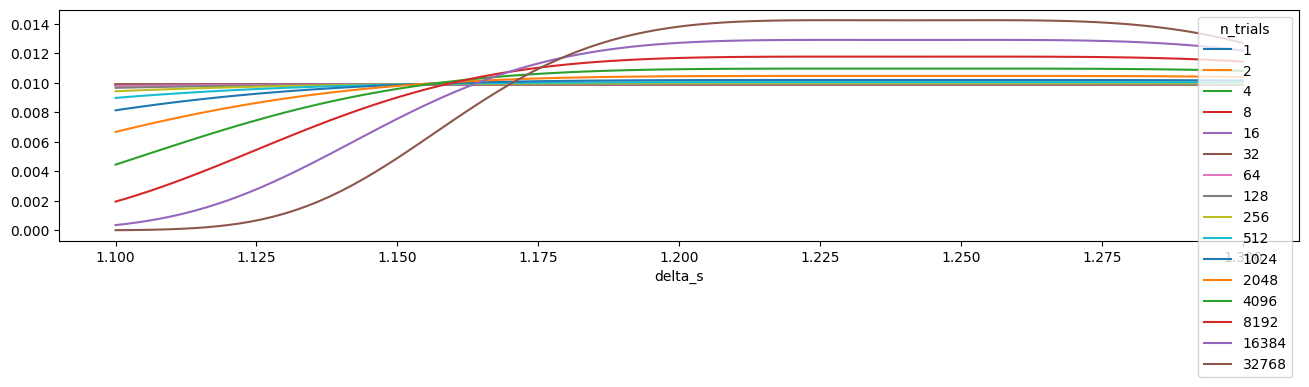

In [14]:
# TODO: We need to replace sum with a more appropriate calculation
likelihood_df = temp_df\
    .groupby([parameter, "n_trials"])["log_likelihood"]\
    .agg(lambda row: np.sum(np.exp(row)))\
    .reset_index()\
    .pivot(columns="n_trials", index=parameter, values="log_likelihood")

likelihood_df /= likelihood_df.sum(axis=0)
# mean = np.divide(df["delta_s"] @ df["likelihood"], df["likelihood"].sum())
likelihood_df.plot.line(figsize=(16,3))

In [44]:
likelihood_df

n_trials,1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768
delta_s,,,,,,,,,,,,,,,,
1.100,0.009899,0.009897,0.009893,0.009886,0.009871,0.009841,0.009781,0.009663,0.009430,0.008980,0.008139,0.006673,0.004457,0.001950,0.000357,0.000011
1.102,0.009899,0.009897,0.009894,0.009887,0.009873,0.009845,0.009790,0.009679,0.009462,0.009041,0.008250,0.006857,0.004707,0.002174,0.000443,0.000017
1.104,0.009899,0.009898,0.009894,0.009888,0.009875,0.009849,0.009798,0.009695,0.009493,0.009100,0.008358,0.007038,0.004958,0.002412,0.000545,0.000026
1.106,0.009899,0.009898,0.009895,0.009889,0.009877,0.009853,0.009805,0.009710,0.009522,0.009156,0.008462,0.007214,0.005209,0.002662,0.000664,0.000039
1.108,0.009900,0.009898,0.009895,0.009890,0.009879,0.009857,0.009812,0.009724,0.009550,0.009210,0.008562,0.007386,0.005459,0.002923,0.000800,0.000056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.292,0.009901,0.009902,0.009902,0.009903,0.009905,0.009910,0.009919,0.009936,0.009971,0.010040,0.010175,0.010428,0.010879,0.011592,0.012508,0.013371
1.294,0.009901,0.009902,0.009902,0.009903,0.009905,0.009910,0.009918,0.009936,0.009970,0.010039,0.010171,0.010421,0.010864,0.011561,0.012440,0.013226
1.296,0.009901,0.009902,0.009902,0.009903,0.009905,0.009910,0.009918,0.009935,0.009970,0.010037,0.010167,0.010413,0.010848,0.011526,0.012364,0.013066


In [58]:
aggregates = pd.DataFrame()
parameter_means = np.divide(
    np.array(likelihood_df.index) @ np.array(likelihood_df),
    np.array(likelihood_df.sum(axis=0))
)
aggregates = pd.concat([aggregates, pd.DataFrame({
    "variable": parameter,
    "n_trials": likelihood_df.columns,
    "mean": parameter_means,
    "var":
})])
aggregates

,variable,n_trials,mean
0,delta_s,1,1.200002
1,delta_s,2,1.200005
2,delta_s,4,1.200009
3,delta_s,8,1.200019
4,delta_s,16,1.200037
5,delta_s,32,1.200074
6,delta_s,64,1.200148
7,delta_s,128,1.200295
8,delta_s,256,1.200588
9,delta_s,512,1.201164


In [55]:
np.divide(
        np.array(likelihood_df.index) @ np.array(likelihood_df),
        np.array(likelihood_df.sum(axis=0))
    )

array([1.20000232, 1.20000464, 1.20000928, 1.20001856, 1.2000371 ,
       1.20007416, 1.20014813, 1.20029548, 1.20058791, 1.20116366,
       1.20227948, 1.20437395, 1.20806032, 1.21378524, 1.22096865,
       1.2279412 ])